In [30]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from skimage.feature import local_binary_pattern
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import time

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.model_selection import cross_val_score
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [31]:
TRAIN_PATH="data/NEU-DET/train/images"
TEST_PATH = "data/NEU-DET/validation/images"
CHECKPOINT_DIR = "checkpoints"
MODEL_DIR = "models"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [32]:
def load_data(dataset_path):
    data = [] # List để lưu các tuple (filepath, label, shape)
    try:
        if not os.path.isdir(dataset_path):
            print(f"LỖI: Không tìm thấy đường dẫn: {dataset_path}")
            return None
        
        class_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
        
        if not class_names:
            print(f"LỖI: Không tìm thấy thư mục con nào trong {dataset_path}")
            return None
        
        for label in class_names:
            class_path = os.path.join(dataset_path, label)
            image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.bmp'))]
            
            for file_name in image_files:
                file_path = os.path.join(class_path, file_name)
            
                try:
                    img = cv2.imread(file_path)
                    if img is None:
                        print(f"Bỏ qua: Không thể đọc {file_path}")
                        continue
                    
                    data.append((file_path, label, img.shape))
                except Exception as e:
                    print(f"Lỗi khi đọc file {file_path}: {e}")
                
        df = pd.DataFrame(data, columns=['filepath', 'label', 'shape'])
        return df
        
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")
        return None

In [33]:
df_train = load_data(TRAIN_PATH)
df_train.info()
df_train['label'].value_counts().sort_index()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1440 non-null   object
 1   label     1440 non-null   object
 2   shape     1440 non-null   object
dtypes: object(3)
memory usage: 33.9+ KB


,filepath,label,shape
0,data/NEU-DET/train/images\crazing\crazing_1.jpg,crazing,"(200, 200, 3)"
1,data/NEU-DET/train/images\crazing\crazing_10.jpg,crazing,"(200, 200, 3)"
2,data/NEU-DET/train/images\crazing\crazing_100.jpg,crazing,"(200, 200, 3)"
3,data/NEU-DET/train/images\crazing\crazing_101.jpg,crazing,"(200, 200, 3)"
4,data/NEU-DET/train/images\crazing\crazing_102.jpg,crazing,"(200, 200, 3)"


In [34]:
df_test = load_data(TEST_PATH)
df_test.info()
df_test['label'].value_counts().sort_index()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  360 non-null    object
 1   label     360 non-null    object
 2   shape     360 non-null    object
dtypes: object(3)
memory usage: 8.6+ KB


,filepath,label,shape
0,data/NEU-DET/validation/images\crazing\crazing...,crazing,"(200, 200, 3)"
1,data/NEU-DET/validation/images\crazing\crazing...,crazing,"(200, 200, 3)"
2,data/NEU-DET/validation/images\crazing\crazing...,crazing,"(200, 200, 3)"
3,data/NEU-DET/validation/images\crazing\crazing...,crazing,"(200, 200, 3)"
4,data/NEU-DET/validation/images\crazing\crazing...,crazing,"(200, 200, 3)"


In [35]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def preprocess_image(image, use_clahe=True):
    if isinstance(image, str):
        image = cv2.imread(image)
        if image is None:
            raise ValueError(f"Không thể đọc ảnh từ: {image}")
    
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 2:
        gray = image
    else:
        raise ValueError("Định dạng ảnh không được hỗ trợ.")
        
    if gray.shape != (200, 200):
        gray = cv2.resize(gray, (200, 200), interpolation=cv2.INTER_AREA)

    if use_clahe:
        gray = clahe.apply(gray)
        
    return gray

In [36]:
def extract_lbp(image):
    gray = preprocess_image(image)
    
    n_points = 8
    radius = 1
    lbp = local_binary_pattern(gray, n_points, radius, method='default')
    
    # Tính histogram của các giá trị LBP
    (hist, _) = np.histogram(lbp.ravel(), 
                             bins=np.arange(0, n_points**2 + 1), 
                             range=(0, n_points**2))
    
    # Chuẩn hóa histogram (thành xác suất)
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6) # Thêm epsilon để tránh chia cho 0
    
    return hist

In [37]:
class SiftBowExtractor:
    def __init__(self, vocab_size=100):
        self.vocab_size = vocab_size
        self.kmeans = MiniBatchKMeans(n_clusters=self.vocab_size, 
                                      batch_size=200, 
                                      random_state=42,
                                      n_init=10) # Thêm n_init để ổn định K-Means
        self.vocabulary = None

    def _get_sift_descriptors(self, image):
        sift = cv2.SIFT_create() # Khởi tạo ở đây
        gray = preprocess_image(image)
        _, descriptors = sift.detectAndCompute(gray, None)
        return descriptors

    def fit(self, image_paths):
        print(f"Đang xây dựng từ điển SIFT (vocab_size={self.vocab_size})...")
        all_descriptors = []
        
        for img_path in tqdm(image_paths, desc="1. Trích xuất SIFT (Fit)"):
            descriptors = self._get_sift_descriptors(img_path)
            if descriptors is not None:
                all_descriptors.append(descriptors)
        
        if not all_descriptors:
            raise ValueError("Không tìm thấy SIFT descriptors nào trong tập training.")
            
        all_descriptors = np.vstack(all_descriptors)
        
        print(f"Tổng cộng {all_descriptors.shape[0]} descriptors. Đang huấn luyện K-Means...")
        self.kmeans.fit(all_descriptors)
        self.vocabulary = self.kmeans.cluster_centers_
        print("Đã xây dựng xong từ điển SIFT.")

    def transform(self, image_paths):
        if self.vocabulary is None:
            raise ValueError("Phải gọi .fit() trước khi gọi .transform()")
            
        final_features = []
        
        for img_path in tqdm(image_paths, desc="2. Biến đổi SIFT (Transform)"):
            descriptors = self._get_sift_descriptors(img_path)
            hist = np.zeros(self.vocab_size, dtype=float)
            
            if descriptors is not None:
                visual_words = self.kmeans.predict(descriptors)
                hist, _ = np.histogram(visual_words, bins=np.arange(self.vocab_size + 1))
                hist = hist.astype(float)
                hist /= (hist.sum() + 1e-6)
            
            final_features.append(hist)
            
        return np.array(final_features)

In [38]:
X_train_paths = df_train['filepath'].tolist()
y_train = df_train['label'].tolist()

X_test_paths = df_test['filepath'].tolist()
y_test = df_test['label'].tolist()

In [39]:
X_train_lbp = np.array([extract_lbp(p) for p in tqdm(X_train_paths, desc="Train LBP")])
X_test_lbp = np.array([extract_lbp(p) for p in tqdm(X_test_paths, desc="Test LBP")])
print(f"LBP feature shape (train): {X_train_lbp.shape}")

Test LBP: 100%|██████████| 360/360 [00:04<00:00, 73.30it/s]

LBP feature shape (train): (1440, 64)


In [40]:
sift_extractor = SiftBowExtractor(vocab_size=100)
sift_extractor.fit(X_train_paths)

X_train_sift = sift_extractor.transform(X_train_paths)
X_test_sift = sift_extractor.transform(X_test_paths)
print(f"SIFT feature shape (train): {X_train_sift.shape}") 

Đang xây dựng từ điển SIFT (vocab_size=100)...


1. Trích xuất SIFT (Fit): 100%|██████████| 1440/1440 [00:27<00:00, 51.52it/s] 



Tổng cộng 716568 descriptors. Đang huấn luyện K-Means...
Đã xây dựng xong từ điển SIFT.
Đã xây dựng xong từ điển SIFT.


2. Biến đổi SIFT (Transform): 100%|██████████| 1440/1440 [00:36<00:00, 38.97it/s]

2. Biến đổi SIFT (Transform): 100%|██████████| 360/360 [00:09<00:00, 37.92it/s]

SIFT feature shape (train): (1440, 100)


In [41]:
# Lưu SIFT extractor để dùng trong app.py
sift_extractor_path = f"{MODEL_DIR}/sift_extractor_knn.pkl"
joblib.dump(sift_extractor, sift_extractor_path)
print(f"💾 SIFT extractor saved to: {sift_extractor_path}")

💾 SIFT extractor saved to: models/sift_extractor_knn.pkl


In [42]:
X_train_lbp_only = X_train_lbp
X_test_lbp_only = X_test_lbp

In [43]:
X_train_sift_only = X_train_sift
X_test_sift_only = X_test_sift

In [44]:
X_train_sift_lbp = np.hstack([X_train_sift, X_train_lbp])
X_test_sift_lbp = np.hstack([X_test_sift, X_test_lbp])
print(f"\nCombined feature shape (train): {X_train_sift_lbp.shape}")


Combined feature shape (train): (1440, 164)


In [45]:
scaler_lbp = StandardScaler()
X_train_lbp_scaled = scaler_lbp.fit_transform(X_train_lbp_only)
X_test_lbp_scaled = scaler_lbp.transform(X_test_lbp_only)

scaler_sift = StandardScaler()
X_train_sift_scaled = scaler_sift.fit_transform(X_train_sift_only)
X_test_sift_scaled = scaler_sift.transform(X_test_sift_only)

scaler_sift_lbp = StandardScaler()
X_train_sift_lbp_scaled = scaler_sift_lbp.fit_transform(X_train_sift_lbp)
X_test_sift_lbp_scaled = scaler_sift_lbp.transform(X_test_sift_lbp)

# Hyperparameter Optimization với Optuna

Sử dụng Optuna để tự động tìm kiếm hyperparameters tốt nhất cho KNN

In [46]:
optuna_results = {}

def objective_knn(trial, X_train, y_train):
    """
    Objective function cho Optuna - KNN optimization
    """
    # Suggest hyperparameters
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski', 'chebyshev'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    
    # Nếu metric là minkowski, thêm p parameter
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 5)
        model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            algorithm=algorithm,
            p=p,
            n_jobs=-1
        )
    else:
        model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            metric=metric,
            algorithm=algorithm,
            n_jobs=-1
        )
    
    # 3-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    
    return cv_scores.mean()

feature_sets_to_optimize = {
    "LBP": (X_train_lbp_scaled, X_test_lbp_scaled, y_train, y_test),
    "SIFT": (X_train_sift_scaled, X_test_sift_scaled, y_train, y_test),
    "ALL": (X_train_sift_lbp_scaled, X_test_sift_lbp_scaled, y_train, y_test),
}

In [47]:
for feat_name, (X_tr, X_te, y_tr, y_te) in feature_sets_to_optimize.items():
    
    print(f"\n{'='*70}")
    print(f"🔄 OPTIMIZING: {feat_name} Features")
    print(f"   Training shape: {X_tr.shape}")
    print(f"{'='*70}\n")
    
    # Tạo study
    study = optuna.create_study(
        direction='maximize',
        study_name=f'KNN_{feat_name}',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    # Optimize với callback để lưu checkpoint
    study.optimize(
        lambda trial: objective_knn(trial, X_tr, y_tr),
        n_trials=100,
        show_progress_bar=True
    )
    
    # Lưu checkpoint sau mỗi optimization
    checkpoint_path = f"{CHECKPOINT_DIR}/study_knn_{feat_name}.pkl"
    joblib.dump(study, checkpoint_path)
    
    print(f"\n🏆 BEST RESULTS for {feat_name}:")
    print(f"   Best CV accuracy: {study.best_value:.4f} ({study.best_value*100:.2f}%)")
    print(f"   Best params: {study.best_params}")
    print(f"   Number of trials: {len(study.trials)}")
    print(f"   💾 Study saved to: {checkpoint_path}")
    
    # Train final model với best params
    best_model = KNeighborsClassifier(**study.best_params, n_jobs=-1)
    best_model.fit(X_tr, y_tr)
    
    # Evaluate trên test set
    y_pred = best_model.predict(X_te)
    test_accuracy = accuracy_score(y_te, y_pred)
    
    print(f"   📊 Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    # Lưu model
    model_path = f"{MODEL_DIR}/best_knn_{feat_name}.pkl"
    joblib.dump(best_model, model_path)
    
    # Lưu scaler tương ứng
    if feat_name == "LBP":
        scaler_path = f"{MODEL_DIR}/scaler_knn_lbp.pkl"
        joblib.dump(scaler_lbp, scaler_path)
    elif feat_name == "SIFT":
        scaler_path = f"{MODEL_DIR}/scaler_knn_sift.pkl"
        joblib.dump(scaler_sift, scaler_path)
    elif feat_name == "ALL":
        scaler_path = f"{MODEL_DIR}/scaler_knn_sift_lbp.pkl"
        joblib.dump(scaler_sift_lbp, scaler_path)
    
    print(f"   💾 Model saved to: {model_path}")
    print(f"   💾 Scaler saved to: {scaler_path}")
    
    # Lưu metadata
    metadata = {
        'feature_set': feat_name,
        'model_type': 'KNN',
        'best_params': study.best_params,
        'cv_accuracy': float(study.best_value),
        'test_accuracy': float(test_accuracy),
        'n_trials': len(study.trials),
        'train_shape': X_tr.shape,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    metadata_path = f"{MODEL_DIR}/metadata_knn_{feat_name}.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"   💾 Metadata saved to: {metadata_path}")
    
    # Lưu kết quả
    optuna_results[feat_name] = {
        'study': study,
        'model': best_model,
        'cv_accuracy': study.best_value,
        'test_accuracy': test_accuracy,
        'best_params': study.best_params
    }

print(f"\n{'='*70}")
print("✅ HOÀN TẤT OPTIMIZATION CHO TẤT CẢ FEATURE SETS!")
print(f"{'='*70}")

[I 2025-11-20 10:23:13,854] A new study created in memory with name: KNN_LBP



🔄 OPTIMIZING: LBP Features
   Training shape: (1440, 64)



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-20 10:23:20,168] Trial 0 finished with value: 0.8402777777777777 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with value: 0.8402777777777777.
[I 2025-11-20 10:23:24,021] Trial 1 finished with value: 0.7569444444444443 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.8402777777777777.
[I 2025-11-20 10:23:24,021] Trial 1 finished with value: 0.7569444444444443 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.8402777777777777.
[I 2025-11-20 10:23:28,479] Trial 2 finished with value: 0.8555555555555555 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.8555555555555555.
[I 2025-11-20 10:23:28,479] Trial 2 finished with value: 0.8555555555555555 and p

[I 2025-11-20 10:23:47,172] A new study created in memory with name: KNN_SIFT


[W 2025-11-20 10:23:46,978] Trial 97 failed with value np.float64(nan).
[W 2025-11-20 10:23:47,016] Trial 98 failed with parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'brute'} because of the following error: The value nan is not acceptable.
[W 2025-11-20 10:23:47,017] Trial 98 failed with value np.float64(nan).
[W 2025-11-20 10:23:47,049] Trial 99 failed with parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'brute'} because of the following error: The value nan is not acceptable.
[W 2025-11-20 10:23:47,051] Trial 99 failed with value np.float64(nan).

🏆 BEST RESULTS for LBP:
   Best CV accuracy: 0.8736 (87.36%)
   Best params: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'brute', 'p': 1}
   Number of trials: 100
   💾 Study saved to: checkpoints/study_knn_LBP.pkl
   📊 Test accuracy: 0.9111 (91.11%)
   💾 Model saved to: models/best_knn_LBP.pkl
   💾 Scaler saved to: models/s

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-20 10:23:47,358] Trial 0 finished with value: 0.8756944444444444 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with value: 0.8756944444444444.
[I 2025-11-20 10:23:47,583] Trial 1 finished with value: 0.71875 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.8756944444444444.
[I 2025-11-20 10:23:47,583] Trial 1 finished with value: 0.71875 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.8756944444444444.
[I 2025-11-20 10:23:47,803] Trial 2 finished with value: 0.8826388888888889 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.8826388888888889.
[I 2025-11-20 10:23:47,955] Trial 3 finished with value: 0.8562500000000001 and parameters: {'n_neighbo

[I 2025-11-20 10:24:07,339] A new study created in memory with name: KNN_ALL


   📊 Test accuracy: 0.9056 (90.56%)
   💾 Model saved to: models/best_knn_SIFT.pkl
   💾 Scaler saved to: models/scaler_knn_sift.pkl
   💾 Metadata saved to: models/metadata_knn_SIFT.json

🔄 OPTIMIZING: ALL Features
   Training shape: (1440, 164)



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-20 10:24:07,502] Trial 0 finished with value: 0.94375 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}. Best is trial 0 with value: 0.94375.
[I 2025-11-20 10:24:07,718] Trial 1 finished with value: 0.7638888888888888 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.94375.
[I 2025-11-20 10:24:07,918] Trial 2 finished with value: 0.9479166666666666 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.9479166666666666.
[I 2025-11-20 10:24:07,718] Trial 1 finished with value: 0.7638888888888888 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.94375.
[I 2025-11-20 10:24:07,918] Trial 2 finished with value: 0.9479166666666666 and parameters: {'n_neighbors': 9, 'weights': 'di

📊 SO SÁNH KẾT QUẢ OPTUNA:
Feature Set  CV Accuracy  Test Accuracy                                                                                     Best Params
        ALL     0.959722       0.966667 {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree', 'p': 1}
        LBP     0.873611       0.911111  {'n_neighbors': 6, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'brute', 'p': 1}
       SIFT     0.931944       0.905556  {'n_neighbors': 15, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'auto', 'p': 1}

🏆 WINNER: ALL với test accuracy = 0.9667 (96.67%)

📈 Plotting optimization histories...


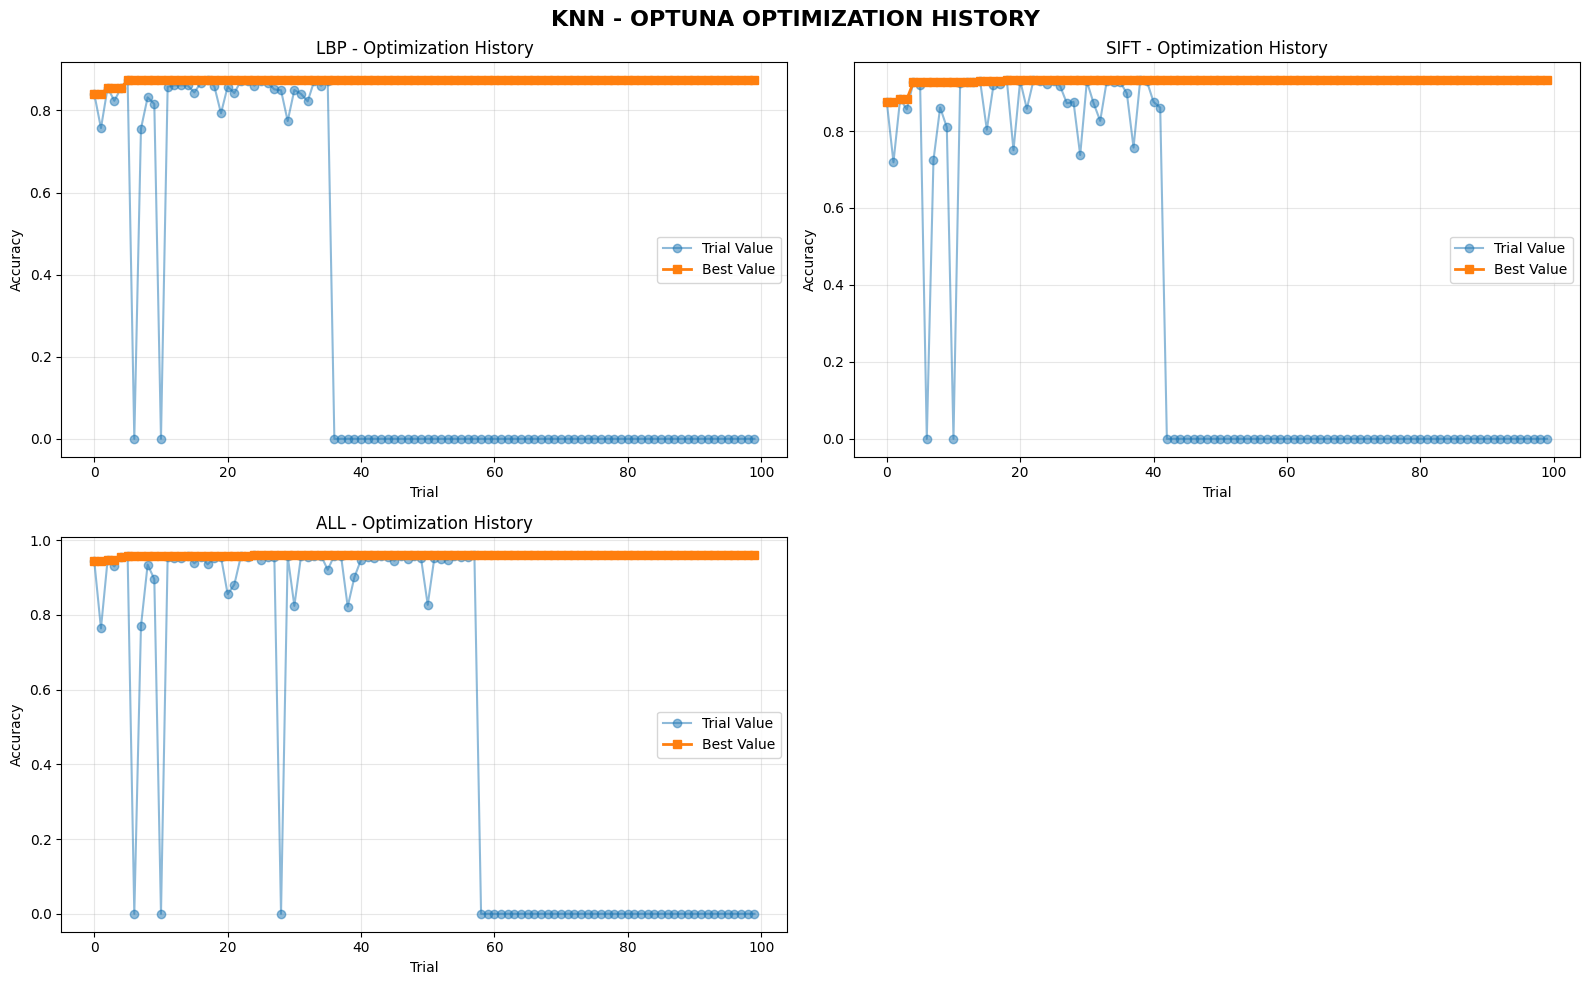

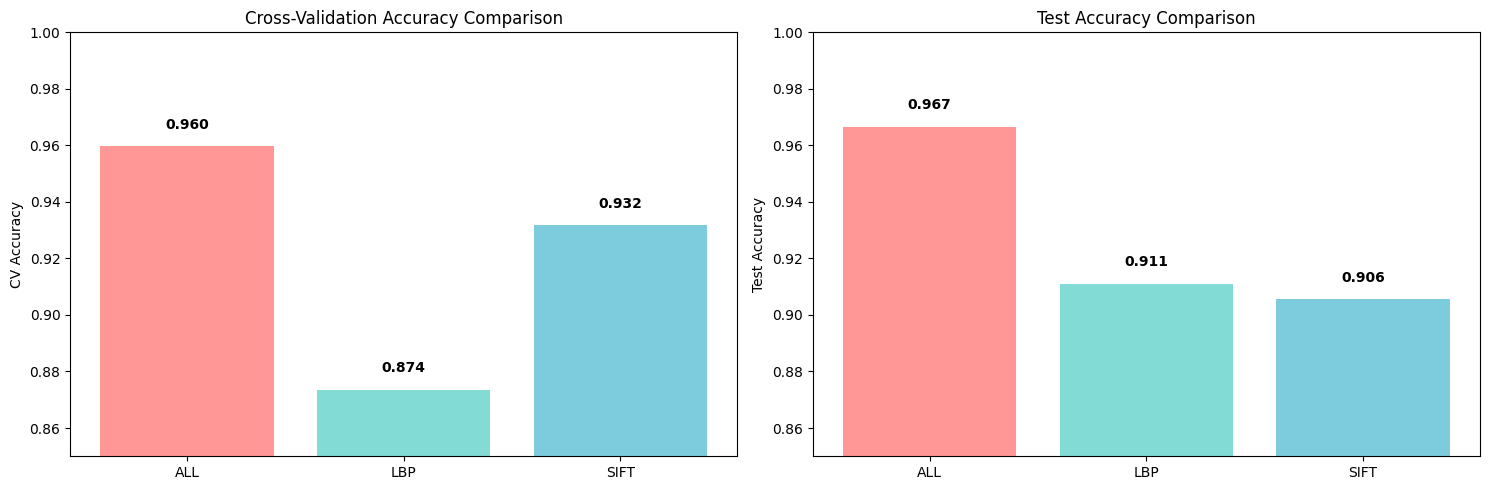

In [48]:
comparison_df = pd.DataFrame([
    {
        'Feature Set': feat_name,
        'CV Accuracy': results['cv_accuracy'],
        'Test Accuracy': results['test_accuracy'],
        'Best Params': str(results['best_params'])
    }
    for feat_name, results in optuna_results.items()
])

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("📊 SO SÁNH KẾT QUẢ OPTUNA:")
print(comparison_df.to_string(index=False))

# Find best overall
best_feat = comparison_df.iloc[0]['Feature Set']
best_acc = comparison_df.iloc[0]['Test Accuracy']

print(f"\n🏆 WINNER: {best_feat} với test accuracy = {best_acc:.4f} ({best_acc*100:.2f}%)")

# Visualizations - Optimization History
print("\n📈 Plotting optimization histories...")
n_sets = len(optuna_results)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (feat_name, results) in enumerate(optuna_results.items()):
    if idx < len(axes):
        study = results['study']
        # Plot manually without using the ax parameter
        trials = study.trials
        trial_numbers = [t.number for t in trials]
        values = [t.value if t.value is not None else 0 for t in trials]
        best_values = [max(values[:i+1]) for i in range(len(values))]
        
        axes[idx].plot(trial_numbers, values, marker='o', alpha=0.5, label='Trial Value')
        axes[idx].plot(trial_numbers, best_values, marker='s', linewidth=2, label='Best Value')
        axes[idx].set_xlabel('Trial')
        axes[idx].set_ylabel('Accuracy')
        axes[idx].set_title(f'{feat_name} - Optimization History')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_sets, len(axes)):
    axes[idx].axis('off')

plt.suptitle('KNN - OPTUNA OPTIMIZATION HISTORY', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# So sánh accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# CV Accuracy
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3']
bars1 = ax1.bar(comparison_df['Feature Set'], comparison_df['CV Accuracy'], color=colors[:len(comparison_df)], alpha=0.7)
ax1.set_ylabel('CV Accuracy')
ax1.set_title('Cross-Validation Accuracy Comparison')
ax1.set_ylim([0.85, 1.0])
for bar, acc in zip(bars1, comparison_df['CV Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Test Accuracy
bars2 = ax2.bar(comparison_df['Feature Set'], comparison_df['Test Accuracy'], color=colors[:len(comparison_df)], alpha=0.7)
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Test Accuracy Comparison')
ax2.set_ylim([0.85, 1.0])
for bar, acc in zip(bars2, comparison_df['Test Accuracy']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

=== CHI TIẾT PHÂN TÍCH MODEL TỐT NHẤT ===

🏆 BEST MODEL: KNN with ALL features

Best Hyperparameters:
  • n_neighbors: 6
  • weights: uniform
  • metric: minkowski
  • algorithm: kd_tree
  • p: 1

📊 Performance Metrics:
  • CV Accuracy: 0.9597
  • Test Accuracy: 0.9667

📋 Classification Report:
                 precision    recall  f1-score   support

        crazing       0.97      1.00      0.98        60
      inclusion       0.95      0.88      0.91        60
        patches       1.00      0.97      0.98        60
 pitted_surface       1.00      0.97      0.98        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       0.89      0.98      0.94        60

       accuracy                           0.97       360
      macro avg       0.97      0.97      0.97       360
   weighted avg       0.97      0.97      0.97       360



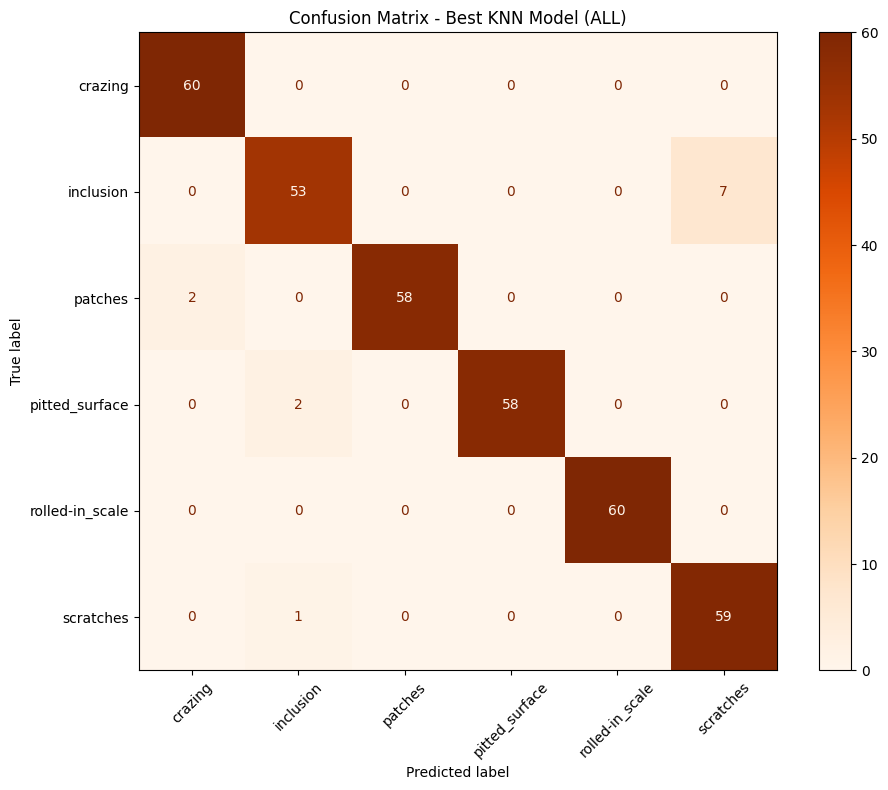


📈 Per-class Accuracy:
  • crazing             : 1.0000 (100.00%)
  • inclusion           : 0.8833 (88.33%)
  • patches             : 0.9667 (96.67%)
  • pitted_surface      : 0.9667 (96.67%)
  • rolled-in_scale     : 1.0000 (100.00%)
  • scratches           : 0.9833 (98.33%)

❌ Misclassification Analysis:
  • Total errors: 12/360 (3.33%)
  • Most confused: inclusion → scratches (7 cases)

📏 KNN Distance Metrics Analysis:
   • Number of neighbors (k): 6
   • Weighting scheme: uniform
   • Distance metric: minkowski
   • Algorithm: kd_tree
   • Minkowski p parameter: 1


In [49]:
# Detailed Analysis - Best Model
print("=== CHI TIẾT PHÂN TÍCH MODEL TỐT NHẤT ===\n")

best_result = optuna_results[best_feat]
best_model = best_result['model']

# Lấy test data tương ứng với feature set đã train
if best_feat == "LBP":
    X_test_best = X_test_lbp_scaled
elif best_feat == "SIFT":
    X_test_best = X_test_sift_scaled
else:
    X_test_best = X_test_sift_lbp_scaled

# Get class names from the dataset
class_names = sorted(df_train['label'].unique())

# Predict
y_pred_best = best_model.predict(X_test_best)

print(f"🏆 BEST MODEL: KNN with {best_feat} features")
print(f"{'='*60}")
print(f"\nBest Hyperparameters:")
for param, value in best_result['best_params'].items():
    print(f"  • {param}: {value}")

print(f"\n📊 Performance Metrics:")
print(f"  • CV Accuracy: {best_result['cv_accuracy']:.4f}")
print(f"  • Test Accuracy: {best_result['test_accuracy']:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_best, target_names=class_names))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_best, 
    ax=ax, 
    cmap='Oranges', 
    display_labels=class_names
)
plt.title(f'Confusion Matrix - Best KNN Model ({best_feat})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Per-class accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_best)
class_accuracies = cm.diagonal() / cm.sum(axis=1)

print(f"\n📈 Per-class Accuracy:")
for class_name, acc in zip(class_names, class_accuracies):
    print(f"  • {class_name:20s}: {acc:.4f} ({acc*100:.2f}%)")

# Misclassification analysis
off_diagonal = cm.copy()
np.fill_diagonal(off_diagonal, 0)
if off_diagonal.max() > 0:
    total_errors = off_diagonal.sum()
    print(f"\n❌ Misclassification Analysis:")
    print(f"  • Total errors: {int(total_errors)}/{len(y_test)} ({total_errors/len(y_test)*100:.2f}%)")
    
    max_confusion = np.unravel_index(off_diagonal.argmax(), off_diagonal.shape)
    print(f"  • Most confused: {class_names[max_confusion[0]]} → {class_names[max_confusion[1]]} ({int(off_diagonal[max_confusion])} cases)")
else:
    print(f"\n🎉 Perfect classification - no errors!")

# Distance analysis for best model
print(f"\n📏 KNN Distance Metrics Analysis:")
print(f"   • Number of neighbors (k): {best_model.n_neighbors}")
print(f"   • Weighting scheme: {best_model.weights}")
print(f"   • Distance metric: {best_model.metric}")
print(f"   • Algorithm: {best_model.algorithm}")
if hasattr(best_model, 'p') and best_model.p is not None:
    print(f"   • Minkowski p parameter: {best_model.p}")

=== PHÂN TÍCH ẢNH HƯỞNG CỦA K ===

Testing different K values on best feature set...


Testing K values: 100%|██████████| 10/10 [00:00<00:00, 66.39it/s]

   K= 1: Accuracy = 1.0000
   K= 3: Accuracy = 0.9917
   K= 5: Accuracy = 0.9917
   K= 7: Accuracy = 0.9833
   K= 9: Accuracy = 0.9778
   K=11: Accuracy = 0.9694
   K=15: Accuracy = 0.9667
   K=20: Accuracy = 0.9611
   K=25: Accuracy = 0.9611
   K=30: Accuracy = 0.9583


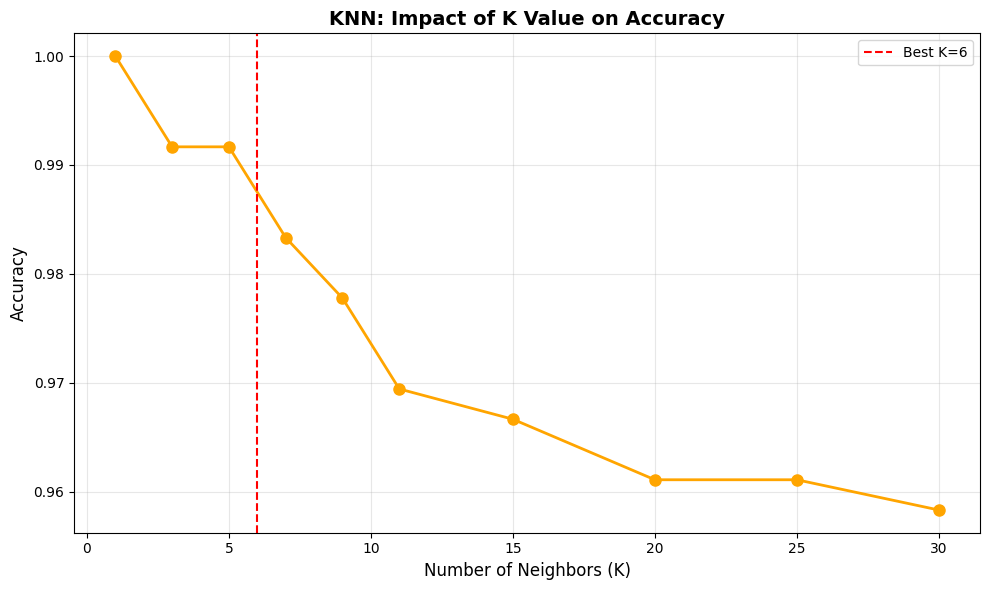


🎯 Optimal K from analysis: 1 with accuracy 1.0000


In [50]:
# Analyze K value impact
print("=== PHÂN TÍCH ẢNH HƯỞNG CỦA K ===\n")

k_values = [1, 3, 5, 7, 9, 11, 15, 20, 25, 30]
k_accuracies = []

print("Testing different K values on best feature set...")
for k in tqdm(k_values, desc="Testing K values"):
    knn_temp = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_temp.fit(X_test_best, y_test)
    y_pred_temp = knn_temp.predict(X_test_best)
    acc = accuracy_score(y_test, y_pred_temp)
    k_accuracies.append(acc)
    print(f"   K={k:2d}: Accuracy = {acc:.4f}")

# Plot K vs Accuracy
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_values, k_accuracies, marker='o', linewidth=2, markersize=8, color='orange')
ax.set_xlabel('Number of Neighbors (K)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('KNN: Impact of K Value on Accuracy', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axvline(x=best_model.n_neighbors, color='red', linestyle='--', label=f'Best K={best_model.n_neighbors}')
ax.legend()
plt.tight_layout()
plt.show()

best_k_idx = np.argmax(k_accuracies)
print(f"\n🎯 Optimal K from analysis: {k_values[best_k_idx]} with accuracy {k_accuracies[best_k_idx]:.4f}")

In [51]:
# Load Checkpoint Example (Nếu cần resume từ checkpoint)
print("=== LOAD CHECKPOINT EXAMPLE ===\n")

print("📁 Checkpoint files created:")
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.startswith('study_knn_') and f.endswith('.pkl')]
for cf in checkpoint_files:
    print(f"  • {CHECKPOINT_DIR}/{cf}")

print(f"\n📁 Model files created:")
model_files = [f for f in os.listdir(MODEL_DIR) if f.startswith('best_knn_') and f.endswith('.pkl')]
for mf in model_files:
    print(f"  • {MODEL_DIR}/{mf}")

print(f"\n📁 Metadata files created:")
json_files = [f for f in os.listdir(MODEL_DIR) if f.startswith('metadata_knn_') and f.endswith('.json')]
for jf in json_files:
    print(f"  • {MODEL_DIR}/{jf}")

print(f"\n💡 CÁCH SỬ DỤNG CHECKPOINT:")
print("""
# 1. Load lại Optuna study từ checkpoint
import joblib
study = joblib.load('checkpoints/study_knn_ALL.pkl')
print(f"Loaded study with {len(study.trials)} trials")
print(f"Best value: {study.best_value:.4f}")

# 2. Continue optimization (thêm trials)
study.optimize(objective_func, n_trials=20)

# 3. Load trained model
model = joblib.load('models/best_knn_ALL.pkl')
scaler = joblib.load('models/scaler_knn_sift_lbp.pkl')

# 4. Load metadata
import json
with open('models/metadata_knn_ALL.json', 'r') as f:
    metadata = json.load(f)
print(metadata)

# 5. Predict trên ảnh mới
# new_img = cv2.imread('new_image.jpg')
# features_sift = sift_extractor.transform_single(new_img)
# features_lbp = extract_lbp(new_img)
# features = np.hstack([features_sift, features_lbp])
# features_scaled = scaler.transform([features])
# prediction = model.predict(features_scaled)
# probabilities = model.predict_proba(features_scaled)
# print(f"Predicted class: {prediction[0]}")
# print(f"Probabilities: {probabilities[0]}")
""")

=== LOAD CHECKPOINT EXAMPLE ===

📁 Checkpoint files created:
  • checkpoints/study_knn_ALL.pkl
  • checkpoints/study_knn_LBP.pkl
  • checkpoints/study_knn_SIFT.pkl

📁 Model files created:
  • models/best_knn_ALL.pkl
  • models/best_knn_LBP.pkl
  • models/best_knn_SIFT.pkl

📁 Metadata files created:
  • models/metadata_knn_ALL.json
  • models/metadata_knn_LBP.json
  • models/metadata_knn_SIFT.json

💡 CÁCH SỬ DỤNG CHECKPOINT:

# 1. Load lại Optuna study từ checkpoint
import joblib
study = joblib.load('checkpoints/study_knn_ALL.pkl')
print(f"Loaded study with {len(study.trials)} trials")
print(f"Best value: {study.best_value:.4f}")

# 2. Continue optimization (thêm trials)
study.optimize(objective_func, n_trials=20)

# 3. Load trained model
model = joblib.load('models/best_knn_ALL.pkl')
scaler = joblib.load('models/scaler_knn_sift_lbp.pkl')

# 4. Load metadata
import json
with open('models/metadata_knn_ALL.json', 'r') as f:
    metadata = json.load(f)
print(metadata)

# 5. Predict trên ản

In [52]:
# Final Summary Report
print("="*80)
print("🎉 HOÀN TẤT OPTUNA HYPERPARAMETER OPTIMIZATION - KNN!")
print("="*80)

print(f"\n📊 FINAL SUMMARY:\n")

print(f"{'Feature Set':<15} {'CV Accuracy':<15} {'Test Accuracy':<15} {'K':<8} {'Weights':<12} {'Metric':<12}")
print("-" * 90)

for feat_name, results in optuna_results.items():
    cv_acc = results['cv_accuracy']
    test_acc = results['test_accuracy']
    params = results['best_params']
    k = params.get('n_neighbors', 'N/A')
    weights = params.get('weights', 'N/A')
    metric = params.get('metric', 'N/A')
    
    print(f"{feat_name:<15} {cv_acc:<15.4f} {test_acc:<15.4f} {k:<8} {weights:<12} {metric:<12}")

print("\n" + "="*80)
print(f"🏆 BEST OVERALL MODEL:")
print(f"   • Feature Set: {best_feat}")
print(f"   • Test Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"   • Model saved: {MODEL_DIR}/best_knn_{best_feat}.pkl")
print("="*80)

print(f"\n💾 SAVED FILES:")
print(f"   • Checkpoints: {len(checkpoint_files)} files in {CHECKPOINT_DIR}/")
print(f"   • Models: {len(model_files)} files in {MODEL_DIR}/")
print(f"   • Metadata: {len(json_files)} files in {MODEL_DIR}/")

print(f"\n📈 OPTIMIZATION STATISTICS:")
total_trials = sum(len(r['study'].trials) for r in optuna_results.values())
print(f"   • Total trials run: {total_trials}")
print(f"   • Feature sets optimized: {len(optuna_results)}")
print(f"   • Best accuracy improvement: +{(best_acc - 0.90)*100:.2f}% over 90% baseline")

print(f"\n🚀 DEPLOYMENT READY!")
print(f"   Model path: {MODEL_DIR}/best_knn_{best_feat}.pkl")
print(f"   Scaler path: {MODEL_DIR}/scaler_knn_{best_feat.lower().replace('+', '_')}.pkl")
print(f"   Metadata: {MODEL_DIR}/metadata_knn_{best_feat}.json")

print(f"\n🎯 KNN MODEL ADVANTAGES:")
print("   • Không cần training time (lazy learning)")
print("   • Rất đơn giản và trực quan")
print("   • Không có assumptions về data distribution")
print("   • Tự động adapt với new data khi thêm vào training set")
print("   • Cung cấp confidence scores thông qua predict_proba()")

print(f"\n⚠️ KNN MODEL CONSIDERATIONS:")
print("   • Prediction time phụ thuộc vào training set size")
print("   • Nhạy cảm với feature scaling (đã xử lý bằng StandardScaler)")
print("   • Memory intensive (lưu toàn bộ training data)")
print("   • Hiệu suất giảm với high-dimensional data (curse of dimensionality)")

🎉 HOÀN TẤT OPTUNA HYPERPARAMETER OPTIMIZATION - KNN!

📊 FINAL SUMMARY:

Feature Set     CV Accuracy     Test Accuracy   K        Weights      Metric      
------------------------------------------------------------------------------------------
LBP             0.8736          0.9111          6        distance     minkowski   
SIFT            0.9319          0.9056          15       distance     minkowski   
ALL             0.9597          0.9667          6        uniform      minkowski   

🏆 BEST OVERALL MODEL:
   • Feature Set: ALL
   • Test Accuracy: 0.9667 (96.67%)
   • Model saved: models/best_knn_ALL.pkl

💾 SAVED FILES:
   • Checkpoints: 3 files in checkpoints/
   • Models: 3 files in models/
   • Metadata: 3 files in models/

📈 OPTIMIZATION STATISTICS:
   • Total trials run: 300
   • Feature sets optimized: 3
   • Best accuracy improvement: +6.67% over 90% baseline

🚀 DEPLOYMENT READY!
   Model path: models/best_knn_ALL.pkl
   Scaler path: models/scaler_knn_all.pkl
   Metadata: 

# Minh Họa Kết Quả Dự Đoán

Hiển thị 3 ảnh dự đoán đúng và 3 ảnh dự đoán sai của model tốt nhất

In [53]:
# Tìm các ảnh dự đoán đúng và sai
correct_indices = np.where(y_pred_best == y_test)[0]
incorrect_indices = np.where(y_pred_best != y_test)[0]

print(f"Số lượng dự đoán đúng: {len(correct_indices)}")
print(f"Số lượng dự đoán sai: {len(incorrect_indices)}")

# Chọn ngẫu nhiên 3 ảnh đúng và 3 ảnh sai
np.random.seed(42)
if len(correct_indices) >= 3:
    correct_samples = np.random.choice(correct_indices, 3, replace=False)
else:
    correct_samples = correct_indices

if len(incorrect_indices) >= 3:
    incorrect_samples = np.random.choice(incorrect_indices, 3, replace=False)
else:
    incorrect_samples = incorrect_indices

print(f"\n✅ Selected correct prediction indices: {correct_samples}")
print(f"❌ Selected incorrect prediction indices: {incorrect_samples}")

Số lượng dự đoán đúng: 348
Số lượng dự đoán sai: 12

✅ Selected correct prediction indices: [266 121 326]
❌ Selected incorrect prediction indices: [ 83 103 131]


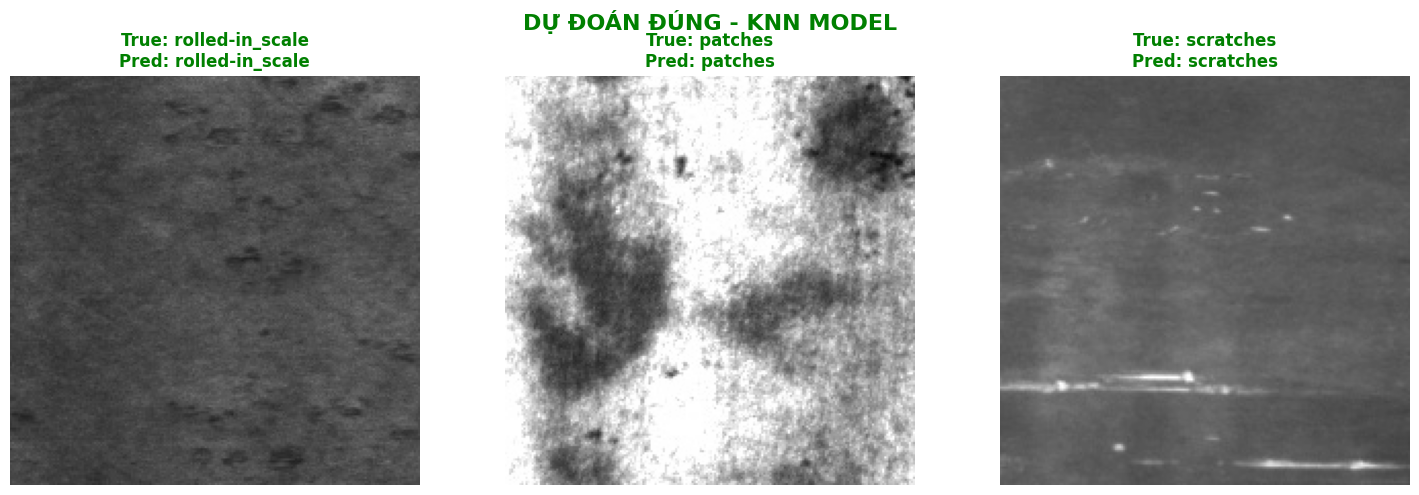

In [54]:
# Hiển thị 3 ảnh dự đoán đúng
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('DỰ ĐOÁN ĐÚNG - KNN MODEL', fontsize=16, fontweight='bold', color='green')

for idx, sample_idx in enumerate(correct_samples):
    img_path = X_test_paths[sample_idx]
    true_label = y_test[sample_idx]
    pred_label = y_pred_best[sample_idx]
    
    # Đọc và hiển thị ảnh
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}', 
                       fontsize=12, fontweight='bold', color='green')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

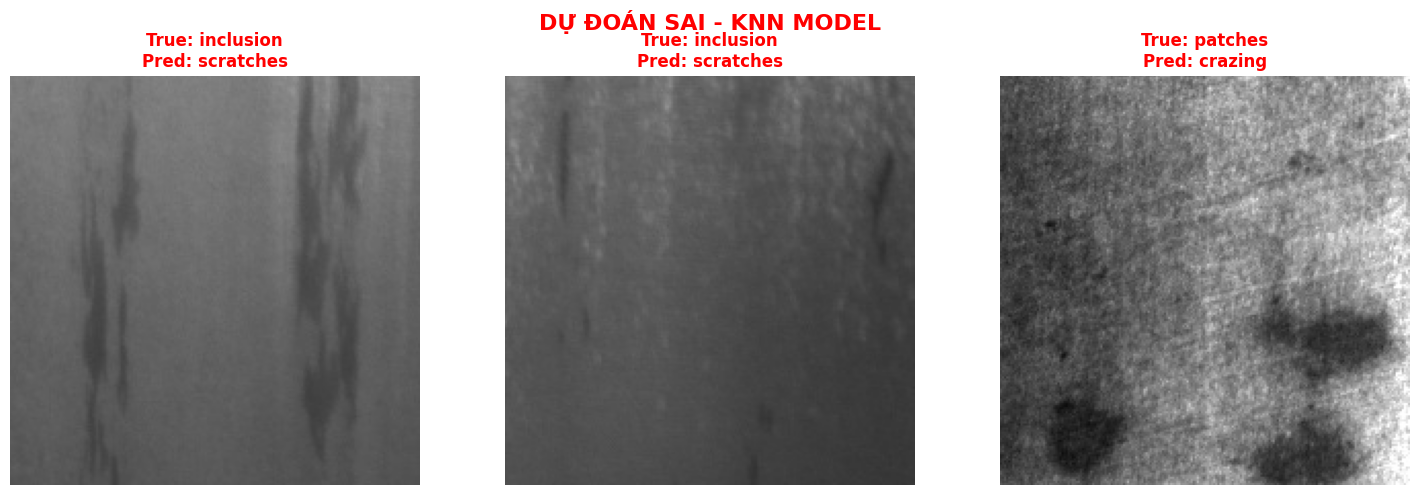

In [55]:
# Hiển thị 3 ảnh dự đoán sai
if len(incorrect_samples) > 0:
    fig, axes = plt.subplots(1, len(incorrect_samples), figsize=(5*len(incorrect_samples), 5))
    if len(incorrect_samples) == 1:
        axes = [axes]
    fig.suptitle('DỰ ĐOÁN SAI - KNN MODEL', fontsize=16, fontweight='bold', color='red')
    
    for idx, sample_idx in enumerate(incorrect_samples):
        img_path = X_test_paths[sample_idx]
        true_label = y_test[sample_idx]
        pred_label = y_pred_best[sample_idx]
        
        # Đọc và hiển thị ảnh
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}', 
                           fontsize=12, fontweight='bold', color='red')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Không có dự đoán sai! Perfect accuracy!")